In [0]:
#offset.dtype

In [0]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/lyqht/googleplaystore-analytics/master/data/reviews_joined.csv", index_col=0)
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop("index", axis=1,inplace=True)
df.columns

Index(['App', 'Review', 'Preprocessed_Review', 'Category', 'Average_Rating',
       'Rating_Label', 'Num_Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Genres', 'Tokens', 'Sentiment', 'Neutral Proportion',
       'Positive Proportion', 'Negative Proportion', 'Compound Score',
       'Sentiment_Rating'],
      dtype='object')

In [0]:
#df.head(2)

In [0]:
print("Number of apps that have reviews")
df["App"].nunique()

Number of apps that have reviews


531

In [0]:
num_reviews_per_app = list(df.groupby(["App","Average_Rating"]).size())
min_num_reviews = int(np.percentile(num_reviews_per_app,25))
print(f"25th percentile of the count of reviews :", min_num_reviews)
print(len(num_reviews_per_app))

25th percentile of the count of reviews : 28
535


In [0]:
num_reviews_per_app = 50
print("Number of Apps that have at least ",num_reviews_per_app, "reviews")
value_counts = df.App.value_counts()
to_keep = value_counts[value_counts >= num_reviews_per_app].index
print(len(to_keep))

df = df[df.App.isin(to_keep)]

df.head(2)
print(df.size)
print("After removing duplicate reviews")
df.drop_duplicates(subset=["Preprocessed_Review","App"],inplace=True, keep="first")
print(df.size)

Number of Apps that have at least  50 reviews
104
246820
After removing duplicate reviews
114060


Create Dummies Variable for the Category


In [0]:
df_dummies = pd.get_dummies(df, prefix_sep='_', drop_first=True,columns = ['Category'])
df_dummies.head()

,App,Review,Preprocessed_Review,Average_Rating,Rating_Label,Num_Reviews,Size,Installs,Type,Price,Content Rating,Genres,Tokens,Sentiment,Neutral Proportion,Positive Proportion,Negative Proportion,Compound Score,Sentiment_Rating,Category_BEAUTY,Category_BUSINESS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_LIFESTYLE,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,like delicious food cooking food case best foo...,4.0,5,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['i', 'like', 'eat', 'delicious', 'food', 'tha...",Positive,0.466,0.534,0.0,0.9531,4.9062,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10 Best Foods for You,This help eating healthy exercise regular basis,help eating healthy exercise regular basis,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['this', 'help', 'eating', 'healthy', 'exercis...",Positive,0.481,0.519,0.0,0.6597,4.3194,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,10 Best Foods for You,Works great especially going grocery store,work great especially going grocery store,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['work', 'great', 'especially', 'going', 'groc...",Positive,0.549,0.451,0.0,0.6249,4.2498,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,10 Best Foods for You,Best idea us,best idea,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['best', 'idea', 'u']",Positive,0.323,0.677,0.0,0.6369,4.2738,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,10 Best Foods for You,Best way,best,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['best', 'way']",Positive,0.192,0.808,0.0,0.6369,4.2738,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
#label the Category in different numbers in the same column 
df_Multi_Category = df
df_Multi_Category.head()
df_Multi_Category['Category'].head()
df_Multi_Category['Category'] = le.fit_transform(df_Multi_Category['Category'])
df_Multi_Category.head(10)

,App,Review,Preprocessed_Review,Category,Average_Rating,Rating_Label,Num_Reviews,Size,Installs,Type,Price,Content Rating,Genres,Tokens,Sentiment,Neutral Proportion,Positive Proportion,Negative Proportion,Compound Score,Sentiment_Rating
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,like delicious food cooking food case best foo...,11,4.0,5,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['i', 'like', 'eat', 'delicious', 'food', 'tha...",Positive,0.466,0.534,0.0,0.9531,4.9062
1,10 Best Foods for You,This help eating healthy exercise regular basis,help eating healthy exercise regular basis,11,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['this', 'help', 'eating', 'healthy', 'exercis...",Positive,0.481,0.519,0.0,0.6597,4.3194
2,10 Best Foods for You,Works great especially going grocery store,work great especially going grocery store,11,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['work', 'great', 'especially', 'going', 'groc...",Positive,0.549,0.451,0.0,0.6249,4.2498
3,10 Best Foods for You,Best idea us,best idea,11,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['best', 'idea', 'u']",Positive,0.323,0.677,0.0,0.6369,4.2738
4,10 Best Foods for You,Best way,best,11,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['best', 'way']",Positive,0.192,0.808,0.0,0.6369,4.2738
5,10 Best Foods for You,Amazing,amazing,11,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,['amazing'],Positive,0.000,1.000,0.0,0.5859,4.1718
11,Hairstyles step by step,Amazing,amazing,1,4.6,4,4369,14000000.0,100000,Free,0,Everyone,Beauty,['amazing'],Positive,0.000,1.000,0.0,0.5859,4.1718
12,Health and Nutrition Guide,Amazing,amazing,11,4.3,4,7895,3300000.0,500000,Free,0,Everyone,Health & Fitness,['amazing'],Positive,0.000,1.000,0.0,0.5859,4.1718
13,10 Best Foods for You,"Looking forward app,",looking forward,11,4.0,3,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['looking', 'forward', 'app']",Neutral,1.000,0.000,0.0,0.0000,3.0000
14,10 Best Foods for You,It helpful site ! It help foods get !,helpful site help food,11,4.0,4,2490,3800000.0,500000,Free,0,Everyone,Health & Fitness,"['it', 'helpful', 'site', 'it', 'help', 'food'...",Positive,0.451,0.549,0.0,0.7256,4.4512


In [0]:
unique_apps = to_keep

print("Creating an array containing arrays of reviews of different apps")
reviews_by_app = [df[df["App"] == unique_apps[i]]["Preprocessed_Review"].to_numpy() for i in range(len(to_keep))]
reviews_by_app
print("Creating an array containing arrays of reviews' sentiment polarity of different apps")
review_sentiment_by_app = [df[df["App"] == unique_apps[i]]["Sentiment_Rating"].to_numpy() for i in range(len(to_keep))]

print("Creating an array containing the actual average rating of different apps")
avr_rating_per_app = [df[df["App"] == unique_apps[i]]["Average_Rating"].to_numpy() for i in range(len(to_keep))]

print(len(review_sentiment_by_app))

Creating an array containing arrays of reviews of different apps
Creating an array containing arrays of reviews' sentiment polarity of different apps
Creating an array containing the actual average rating of different apps
104


In [0]:
#review_sentiment_by_app

In [0]:
#avr_rating_per_app

In [0]:
len(avr_rating_per_app)

104

In [0]:
#reviews_by_app

Using the sentiment polarity as the `x` input with a simple neural network model consisting of 2 layers.



In [0]:
from torch import tensor
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

class SentimentDataset(Dataset):
  def __init__(self, x, y):
    self.samples = x
    self.labels = y
  
  def __len__(self):
    return len(self.samples)
  
  def __getitem__(self,idx):
    item = self.samples[idx]
    item = np.random.choice(item, size=50) # sampling 28 reviews from each app
    return tensor(item, dtype=torch.float), tensor(self.labels[idx][0], dtype=torch.float)

x = review_sentiment_by_app
y = avr_rating_per_app

train_size = int(0.7*len(x))
val_size = len(x) - train_size

data = SentimentDataset(review_sentiment_by_app, avr_rating_per_app)
trainset, valset = random_split(data, [train_size, val_size])
BATCH_SIZE = 5
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("Training dataloader has ", len(train_dataloader), "batches of ", BATCH_SIZE)
print("Validation dataloader has ", len(val_dataloader), "batches of ", BATCH_SIZE)

Training dataloader has  15 batches of  5
Validation dataloader has  7 batches of  5


NORMALIZE LABEL FROM 0 - 1, INPUT NORMALIZE TO 0 - 1 

Net(
  (hidden): Linear(in_features=50, out_features=30, bias=True)
  (predict): Linear(in_features=30, out_features=1, bias=True)
)
Epoch  10 , Loss:  tensor(15.9434, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  20 , Loss:  tensor(0.4837, grad_fn=<MseLossBackward>)
Epoch  30 , Loss:  tensor(0.0415, grad_fn=<MseLossBackward>)
Epoch  40 , Loss:  tensor(0.2308, grad_fn=<MseLossBackward>)
Epoch  50 , Loss:  tensor(0.3558, grad_fn=<MseLossBackward>)
Epoch  60 , Loss:  tensor(0.1822, grad_fn=<MseLossBackward>)
Epoch  70 , Loss:  tensor(0.3355, grad_fn=<MseLossBackward>)
Epoch  80 , Loss:  tensor(0.5479, grad_fn=<MseLossBackward>)
Epoch  90 , Loss:  tensor(0.0539, grad_fn=<MseLossBackward>)
Epoch  100 , Loss:  tensor(0.1991, grad_fn=<MseLossBackward>)


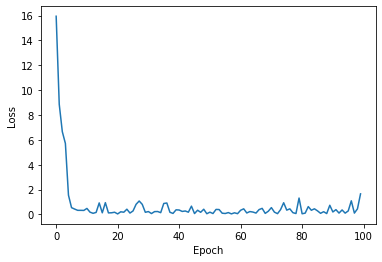

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f55c00d3ba8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [0]:
# !pip install tensorboard
# !tensorboard --logdir=runs
# from torch.utils.tensorboard import SummaryWriter
# import torchvision

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

#RNN module
class Net(nn.Module):
  def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = nn.Linear(n_hidden, n_output)   # output layer

  def forward(self, x):
        #xn = F.sigmoid(self.hidden(x))
        x = F.relu(self.hidden(x))  # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

INPUT_SIZE = num_reviews_per_app
OUTPUT_SIZE = 1 # regression to reach average rating
HIDDEN_SIZE = 30 # arbitrary
learning_rate = 0.0002

net = Net(n_feature=INPUT_SIZE, n_hidden=HIDDEN_SIZE, n_output=OUTPUT_SIZE)
print(net)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()
# writer = SummaryWriter()

num_epochs = 100
losses = []
for i in range(num_epochs):
  for batch_idx, samples in enumerate(train_dataloader):
    x, y = samples
    
    prediction = net(x)
    loss = loss_func(prediction, y)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    # for plotting
  if i % 10 == 0:
      print("Epoch ", i+10, ", Loss: ", loss)
  losses.append(loss)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(losses)),losses)

Loss tensor(0.3361, grad_fn=<MseLossBackward>)
Loss tensor(0.0385, grad_fn=<MseLossBackward>)
Loss tensor(0.2318, grad_fn=<MseLossBackward>)
Loss tensor(0.3610, grad_fn=<MseLossBackward>)
Loss tensor(0.3480, grad_fn=<MseLossBackward>)
Loss tensor(0.2393, grad_fn=<MseLossBackward>)
Loss tensor(0.1849, grad_fn=<MseLossBackward>)
tensor(0.2485, grad_fn=<DivBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


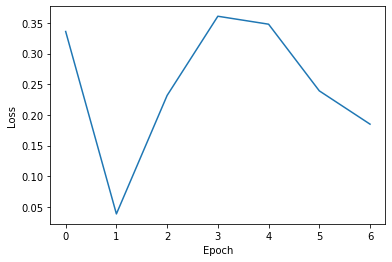

In [0]:
losses = []
for batch_idx, samples in enumerate(val_dataloader):
  x, y = samples
  prediction = net(x)
  #print("Given reviews", x)
  #print("Actual Average Rating", y)
  #print("Predicted ", prediction)
  loss = loss_func(prediction, y)
  print("Loss", loss)
  losses.append(loss)
  aver_MSE_loss = sum(losses)/len(losses)
print(aver_MSE_loss)  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(losses)),losses)

In [0]:
# #LSTM module
# class Net(nn.Module):
#     def __init__(self, n_feature, n_hidden, n_output):
#         super(Net, self).__init__()
        
#         # Recurrent layer
#         self.lstm = nn.LSTM(input_size=n_feature,
#                          hidden_size=n_hidden,
#                          num_layers=1,
#                          bidirectional=False)
        
#         # Output layer
#         self.l_out = nn.Linear(in_features=50,
#                             out_features=n_output,
#                             bias=False)
        
#     def forward(self, x):
#         # RNN returns output and last hidden state
#         x, (h, c) = self.lstm(x)
        
#         # Flatten output for feed-forward layer
#         x = x.view(-1, self.lstm.hidden_size)
        
#         # Output layer
#         x = self.l_out(x)

#         return x

# net = Net(n_feature=INPUT_SIZE, n_hidden=HIDDEN_SIZE, n_output=OUTPUT_SIZE)
# print(net)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = nn.MSELoss()
# # writer = SummaryWriter()

# num_epochs = 100
# losses = []
# for i in range(num_epochs):
#   for batch_idx, samples in enumerate(train_dataloader):
#     x, y = samples
    
#     prediction = net(x)
#     #print(prediction.dim)
#     loss = loss_func(prediction, y)
#     optimizer.zero_grad()   # clear gradients for next train
#     loss.backward()         # backpropagation, compute gradients
#     optimizer.step()        # apply gradients

#     # for plotting
#   if i % 10 == 0:
#       print("Epoch ", i, ", Loss: ", loss)
#   losses.append(loss)

# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.plot(range(len(losses)),losses)